In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

import smfret.evaluation as evaluation

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.multi_task_learning import SavedTraceSet
from smfret.dataset import MatlabTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics

from sciplotlib import style as spstyle

In [127]:
trace_set = SavedTraceSet(file='saved_dataset/test/FRETSTATE_1STATE.npz', size=100)

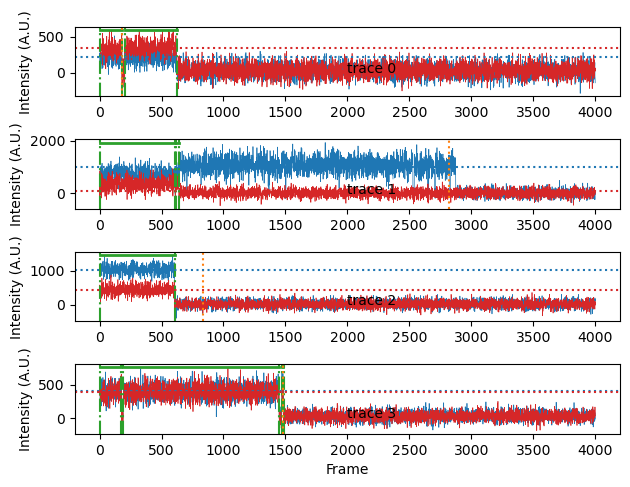

In [37]:
trace_set.plot_traces(n_start=0, n_traces=4)

In [38]:
len(np.unique(trace_set.label[5]))

2

In [129]:
ref_set = trace_set

In [40]:
def use_posterior(prob, max_marginal_prob=0.05):
    marginal_prob = np.mean(prob, axis=-2)
    marginal_prob[marginal_prob >= max_marginal_prob] = max_marginal_prob
    post_prob = np.einsum('itk,ik->itk', prob, marginal_prob)
    return post_prob

In [55]:
ideal_fret = {}
fret_prob = {}
model = keras.models.load_model(f'saved_models/lstm-model-20240423-001233/FRETSTATE_1STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
ideal_fret = FRETStateTraceSet.fret_states_resolution * (tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32) - 1)

79/79 [==============================] - 15s 162ms/step


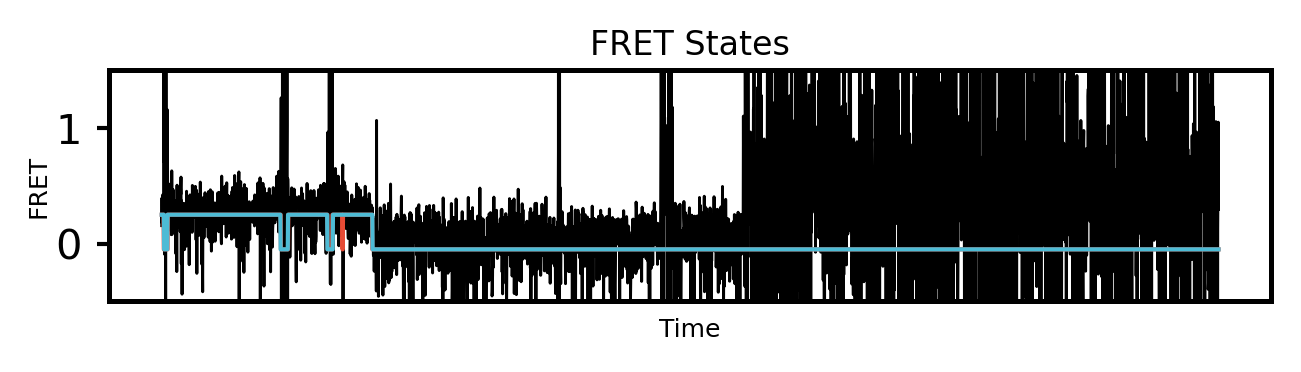

In [56]:
# FRET State
# visualize_set_file = 'saved_dataset/eval/FRETSTATE.npz'
# visualize_set = SavedTraceSet(size=128, file=visualize_set_file)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots(figsize=(5, 1))
    n = 200
    ax.plot(1. * ref_set.traces[n].fret , linewidth=0.7, color='k')
    ax.plot((ref_set.label[n, ...] - 1) * FRETStateTraceSet.fret_states_resolution, linewidth=1)
    ax.plot(ideal_fret[n, ...], linewidth=1)
    ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               labelcolor='0.25')
    plt.xticks([])
    ax.set_ylabel('FRET', fontsize=6, verticalalignment='center')
    ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    plt.ylim(-0.5, 1.5)
    
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    
    ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig('figures/trace_with_fret.svg', transparent=True)

In [75]:
# linetime measurement

def lifetime(label):
    """Finds the lifetime according to the labeled states."""
    l = 0
    label = np.array(label)
    for i in range(len(label) - 1, 0, -1):
        if label[i] > 0:
            return i
    return 0

In [132]:
np.unique(ideal_fret)

array([ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18.], dtype=float32)

In [203]:
ref_set = SavedTraceSet(file='saved_dataset/test/FRETSTATE_1STATE.npz', size=2000)

In [211]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_1STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
true_lifetime = []
predicted_lifetime = []
correct_state_count = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 2)

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))

63/63 [==============================] - 12s 131ms/step


In [223]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 embedding_32 (Embedding)    (None, None, 96)          1732416   
                                                                 
 dense_14 (Dense)            (None, None, 22)          2134      
                                                                 
Total params: 1734550 (6.62 MB)
Trainable params: 1734550 (6.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [236]:
matrix = ref_set.to_tensor()
print(matrix.shape)
%time model.predict(matrix)

(2000, 4000, 4)
63/63 [==============================] - 5s 84ms/step
CPU times: user 4.79 s, sys: 1.37 s, total: 6.16 s
Wall time: 5.68 s


array([[[-0.32703003, -3.4956746 , -3.7531693 , ..., -3.7226217 ,
         -3.0024729 , -3.5002446 ],
        [-1.9781319 , -3.1899061 , -3.6380072 , ..., -3.4206707 ,
         -3.0511756 , -3.3387203 ],
        [-2.4685    , -3.0272007 , -3.708271  , ..., -3.4630356 ,
         -3.0756106 , -3.559455  ],
        ...,
        [21.767347  , -6.0209503 , -6.6211295 , ..., -4.837332  ,
         -6.890152  , -5.5983152 ],
        [22.002474  , -6.1509237 , -6.4337044 , ..., -4.2795906 ,
         -6.5802183 , -5.5353565 ],
        [21.564674  , -6.2738233 , -7.020677  , ..., -4.4897437 ,
         -6.710279  , -5.7592382 ]],

       [[-1.4288079 , -3.5633383 , -3.7140543 , ..., -4.156307  ,
         -3.5986454 , -4.237606  ],
        [-3.0188603 , -3.2367287 , -3.4970982 , ..., -3.891091  ,
         -3.4586248 , -3.9282968 ],
        [-3.9768913 , -3.1189547 , -3.740482  , ..., -4.037904  ,
         -3.5360868 , -4.1142826 ],
        ...,
        [30.454226  , -6.12758   , -6.8928475 , ..., -

In [212]:
for i in range(len(correct_state_count)):
    if not correct_state_count[i]:
        print(i)

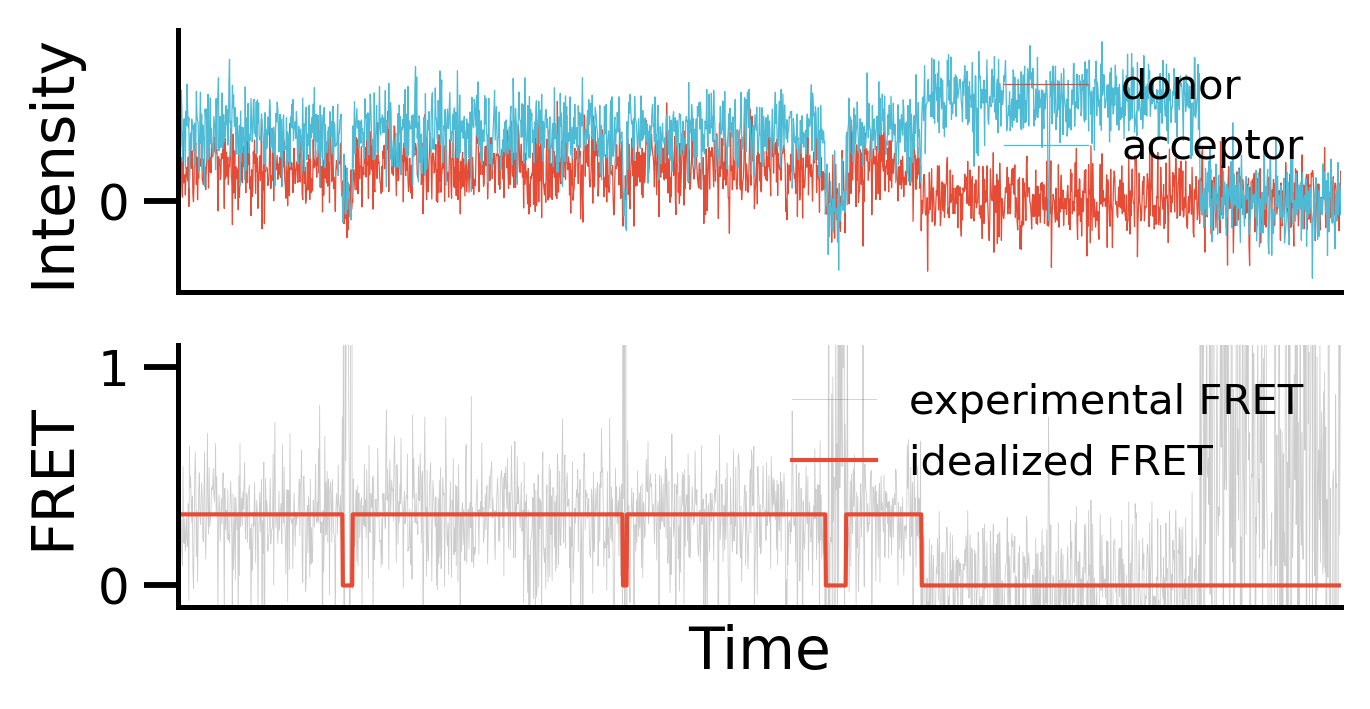

In [222]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    n = 60
    # print(correct_state_count[n])
    ax=axes[0]
    ax.plot(ref_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(ref_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 2000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(ref_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] - 0.5, 0) * FRETStateTraceSet.fret_states_resolution, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 2000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig('figures/trace_with_fret.svg', transparent=True)
    plt.savefig('figures/trace_with_fret.png', transparent=True)

In [208]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
true_lifetime = []
predicted_lifetime = []
correct_state_count = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 2)

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))

63/63 [==============================] - 12s 128ms/step
MAE= 0.793
State Count Accuracy = 0.8195


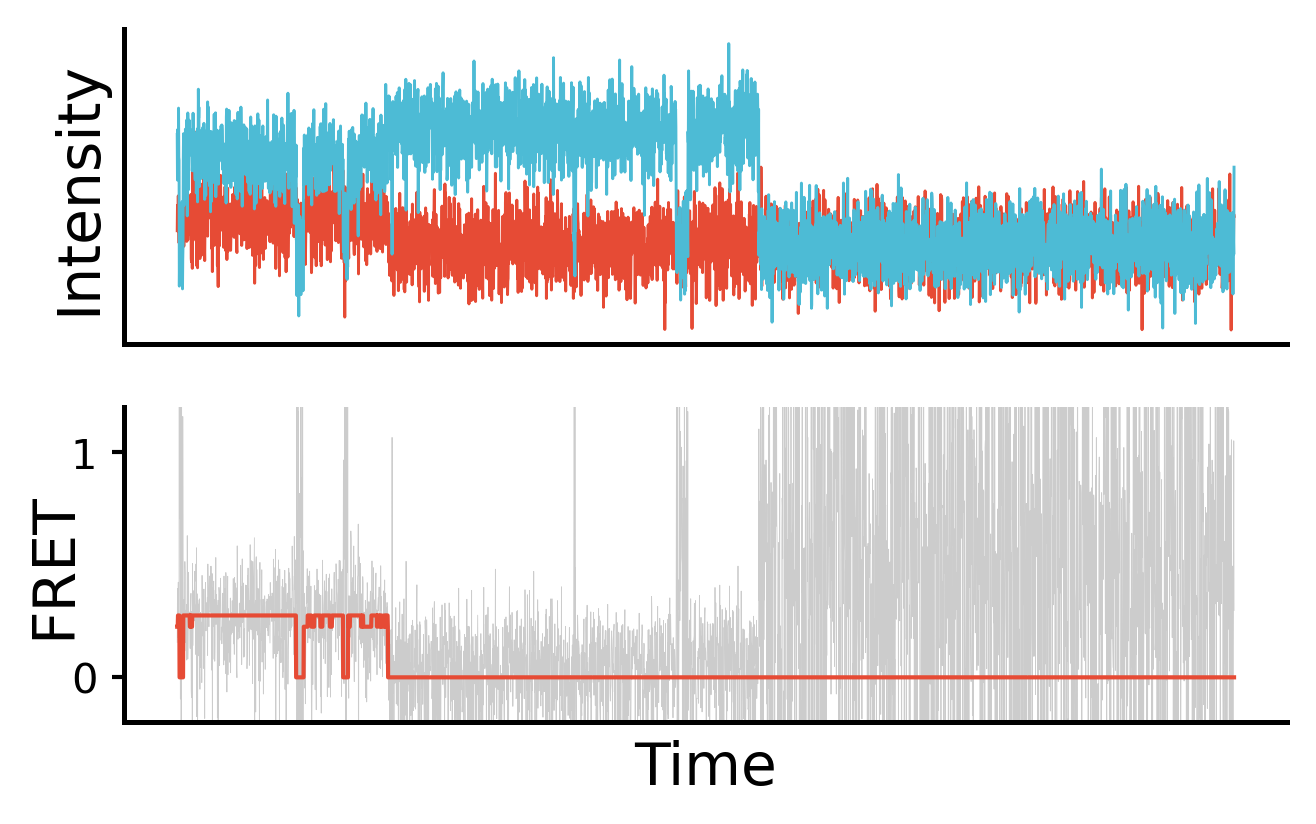

In [209]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 3))
    n = 200
    ax=axes[0]
    ax.plot(ref_set.traces[n].acceptor , linewidth=0.7)
    ax.plot(ref_set.traces[n].donor , linewidth=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    
    ax=axes[1]
    ax.plot(ref_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2)
    ax.plot(np.maximum(ideal_fret[n, ...] - 0.5, 0) * FRETStateTraceSet.fret_states_resolution, linewidth=1)
    ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET', verticalalignment='center')
    ax.set_xlabel('Time', verticalalignment='top')
    plt.ylim(-0.2, 1.2)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig('figures/trace_with_fret.svg', transparent=True)

(array([685., 493., 303., 176., 116.,  89.,  48.,  27.,  21.,  42.]),
 array([ 459.,  813., 1167., 1521., 1875., 2229., 2583., 2937., 3291.,
        3645., 3999.]),
 <BarContainer object of 10 artists>)

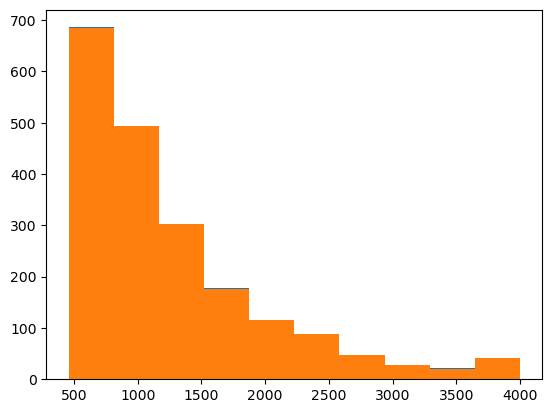

In [210]:
plt.hist(true_lifetime)
plt.hist(predicted_lifetime)